# Heuristic Search 

In [1]:
import gym
import minihack
import numpy as np
import matplotlib.pyplot as plt

from map_utils import *
from search import *
from graphics_utils import *

In [5]:
def solve_and_plt(env: gym.Env, heuristic: callable, precision: str, plt_width: Tuple[int, int], plt_height: Tuple[int, int], dynamic: bool = False, suppress = False):
    state = env.reset()
    game_map = state["chars"]
    color_map = state["colors"]
    pixel_map = state["pixel"]

    start = get_player_location(game_map)
    target = get_target_location(game_map)

    if dynamic:
        dynamic_path_finding(game_map, color_map, start, target, env, heuristic, precision=precision, graphics=True, pixel_map=pixel_map, suppress=suppress)
    else:
        path = a_star(game_map, color_map, start, target, heuristic, precision=precision)
        actions = actions_from_path(start, path[1:])
        render_actions(actions, env, pixel_map, plt_width, plt_height)

## 1. The Fully Observable Environment

The idea was to approach the problem in an increasing level of difficulty, first working on some simpler heuristics and cost functions, up to reaching a more sofisticated level of complexity.


We started by comparing the Euclidean Distance and the Chebyshev Distance, to better understand how to approach the problem.  After a brief analysis, we realized that the Chebyshev Distance was exactly what we needed, because it provided eight normal vectors that accurately matched the possible actions of the agent.

In [ ]:
env = gym.make("MiniHack-Navigation-Custom-v0", observation_keys=("chars", "pixel", "colors"), des_file = "dat/simple_maze.des")
solve_and_plt(env, heuristic=euclidean_distance, precision="base", plt_width=(100, 270), plt_height=(500, 760))

The agent successfully completed the task!


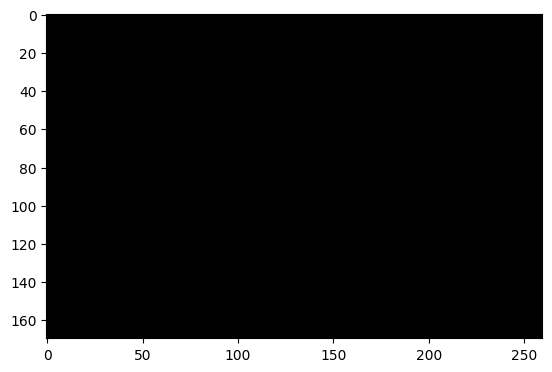

In [ ]:
env = gym.make("MiniHack-Navigation-Custom-v0", observation_keys=("chars", "pixel", "colors"), des_file = "dat/simple_maze.des")
solve_and_plt(env, heuristic=chebyshev_distance, precision="base", plt_width=(100, 270), plt_height=(500, 760))

Initially, a simpler version of the problem was tackled. An A* algorithm that could find the optimal path in a map with trees was implemented .

The agent successfully completed the task!


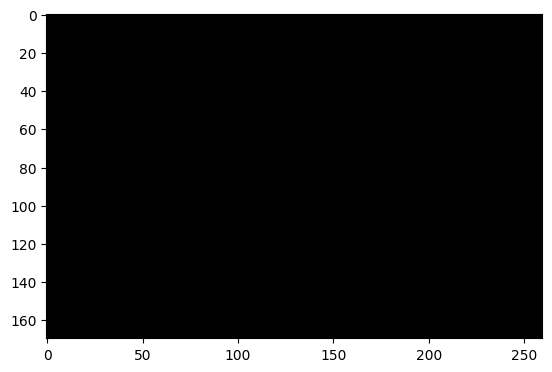

In [ ]:
env = gym.make("MiniHack-Navigation-Custom-v0", observation_keys=["chars", "pixel", "colors"], des_file="dat/square_trees.des")
solve_and_plt(env, heuristic=chebyshev_distance, precision="base", plt_width=(100, 270), plt_height=(500, 760))

The algorithm also worked on more intricate map configurations, that were not constrained to a square shape.

The agent successfully completed the task!


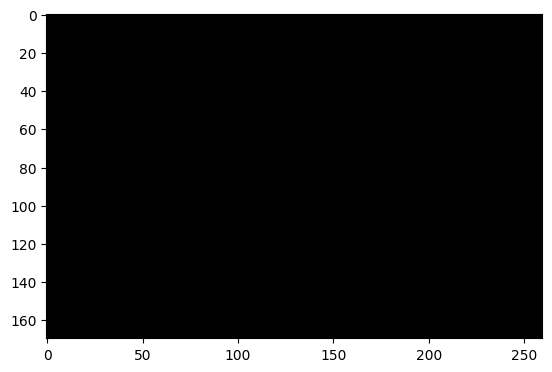

In [ ]:
env = gym.make("MiniHack-Navigation-Custom-v0", observation_keys=["chars", "pixel", "colors"], des_file="dat/maze_trees.des")
solve_and_plt(env, heuristic=chebyshev_distance, precision="base", plt_width=(100, 270), plt_height=(500, 760))

The problem was made more complex with the introduction of clouds and a "grid bug," a relatively weak monster in Nethack. This creature, matching the player's speed, is unable to ever catch up with the agent, adding a strategic element to the scenario. 

To effectively face this issue, a dynamic A* algorithm was implemented. This solution recalculated the path based on whether the monster was visible or not. In scenarios where the monster was visible, the agent incurred no penalties traversing through clouded areas. Instead, in instances where the monster remained hidden, traversing through clouded regions carried a risk, as these areas could have been secret hiding places for the lurking monster.


The agent successfully completed the task!


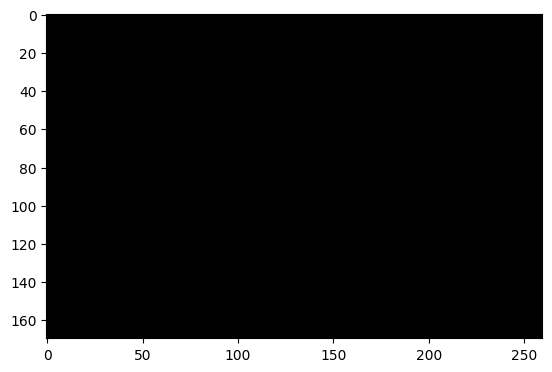

In [ ]:
env = gym.make("MiniHack-Navigation-Custom-v0", observation_keys=["chars", "pixel", "colors"], des_file="dat/grid_bug.des")
solve_and_plt(env, heuristic=chebyshev_distance, precision="base", plt_width=(100, 270), plt_height=(500, 760))

The final stage of the fully observable problem involved addressing the comprehensive challenge at hand. A diverse array of monsters was integrated into the scenario. 

Initially, we relied solely on the strategy discussed up to this point, but we soon realized that it required further refinement.

The agent died.


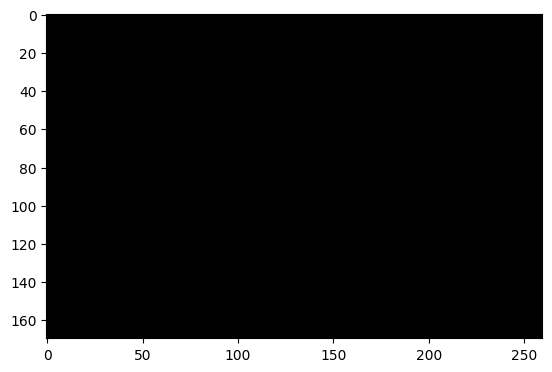

In [ ]:
env = gym.make("MiniHack-HideNSeek-Mapped-v0", observation_keys=["chars", "pixel", "colors"])
solve_and_plt(env, heuristic=chebyshev_distance, precision="base", plt_width=(100, 270), plt_height=(500, 760))

The idea behind the improved strategy roots in two simple concepts:
- when the agent has the chance to see the monster in the map, it should keep itself further from it
- when the agent does not know where the monster might be hiding, it should stay as far away from clouds as possible, for this very reason

The agent died.


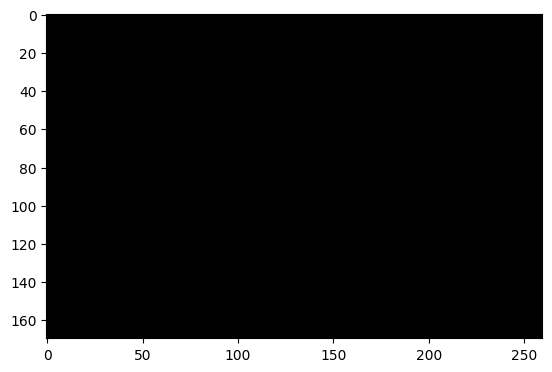

In [ ]:
env = gym.make("MiniHack-HideNSeek-Mapped-v0", observation_keys=["chars", "pixel", "colors"])
solve_and_plt(env, heuristic=chebyshev_distance, precision="advanced", plt_width=(100, 270), plt_height=(500, 760), dynamic=True)

Let us give a brief discussion on the reasons behind the procedure rightfully working.

First, we will introduce the formulation of the Chebyshev Distance, i.e:
$$\text{let} \quad P = (p_1, p_2), \quad \text{and} \quad Q = (q_1, q_2)$$
$$d(P, Q) = \max(|p_1 - q_1|, |p_2 - q_2|)$$

The idea, as expressed before in more abstract terms, is to keep the agent as far as possible from the monster whenever it is visible. This can be obtained by setting the $g$ function of the cost function $f$ in such a way that it weights cells closer to the monster more than cells further from it. 

Let us first define the cost function $f$:
$$f(P, T) := g(P, D) + h(P, T),$$
$$\text{where P is the neighbour position},$$
$$\text{D is the danger position},$$
$$\text{and T is the target position}$$

Note: the definition of the function $g$ must be approached flexibly, as we will see later. It will involve parameters of various types across all instances of the problem. Specifically, $D$ should be considered as a set, and $g$ must be defined as a function with a specific formulation.

Anyway, what we mentioned above can be achieved by a simple manipulation of the function we used for the calculation of the distance between points in the plane, i.e. by simply calculating the reciprocal of the Chebyshev Distance between the position and the monsters itself. This gives us a function which is "rotation aware": it assigns the same value to positions falling in the radius of a circle (really squares to be precise, since the Chebyshev Distance actually is the $L_{\infty}$).

$$\text{let} \quad \text{M be the monster's position},$$
$$\text{and} \quad \psi(P, M) := 
\begin{cases} 
    \frac{1}{d(P, M)}  & \text{if } d(P, M) > 0, \\
    maxcost & \text{if } d(P, M) = 0
\end{cases}, \quad \text{with} \quad maxcost = 10^{5}$$

$$\text{and} \quad h(P, T) := d(P, T)$$

We can obtain the cost function $f$ designed as described by setting $g = \psi$.

Notice that with $g$ we are comparing our neighbouring position $P$ with the monster position $M$, while with $h$ we are computing the exact distance (thanks to the Chebyshev Distance) between the neighbouring position $P$ and the target $T$.

For precision's sake, we implemented the above function with a slight variation. Basically, we considered two different cases from when the agent knows where the monster is: one where $P$ is a cloud, and another one where $P$ is not a cloud. As one might think, it can be advantageous to exploit clouds in order to run off the monster, but clouds have to be weighted carefully. In fact, we did not want the agent to risk running into the monster just because it is trying to get to a cloud. To achieve this goal, we chose a simple yet effective (at least empirically) approach, based on a very simple manipulation of the above function: 


$$\psi(P, M) := 
\begin{cases} 
    \frac{1}{d(P, M)}  & \text{if } d(P, M) > 0 \quad \text{and } P \notin Clouds, \\
    \left \lfloor \frac{1}{d(P, M)} \right \rfloor  & \text{if } d(P, M) > 0 \quad \text{and } P \in Clouds, \\
    maxcost & \text{if } d(P, M) = 0
\end{cases}, \quad \text{with} \quad maxcost = 10^{5}$$

The intuition behind this is that the floor gives a slight advantage to the cloud position in the cost function, precisely an advantage $< 1$. This small adjustment should be enough, given that values will not be too large due to the size of the map, so they will not need major adjustments.

Let us make an observation about what we discussed so far: for now, our approach only targets situations where the agent does not know where the monster is located. However, in scenarios where the monster's position is known, additional considerations are necessary. Here, the agent should be cautious about approaching clouds, as they are ideal places for monsters to hide. To tackle this issue, we developed a specific function:

$$\varphi(P, Clouds) := \sum_{C \in Clouds} \frac{1}{d(P, C)}$$

This function $\varphi$ can be interpreted as the "danger function": it gives a value to represent how "dangerous" a position really is, basing the computation on the distance between a given position and each cloud in the map. To achieve this, we again exploited the reciprocal of the Chebyshev Distance, but this time we summed the amount of "danger" that each cloud have projected to a specific cell.

As before, we use the original formulation, $f(P, T) := g(P, D) + h(P, T)$, to express the cost function, but this time $g = \varphi$.

$$f(P, T) := \sum_{C \in Clouds} \frac{1}{d(P, C)} + h(P, Q)$$

So, we exploited the original formulation of $f$ to handle both scenarios: one where the monster is visible and another where it is not. This was achieved by simply replacing $g$ with the appropriate function for each specific case.

Another important observation is that, when the agent does not know the monster's position, $g$ does not grow linearly as $h$ does, since it is of the form $\frac{1}{n}$ for the most part. This leads to the conclusion that $h$ will have a bigger impact on most cases (i.e. each case where $h(P, T) > g(P, M)$ or, to put it into words, every time the distance from the target is larger than the reciprocal of the distance from the monster, basically in most occasions). When we consider the case of $g = \varphi$, the reasoning actually changes, since we are summing over the number of clouds in the map. In any case, this should not affect the algorithm in any particular way.

To conclude the discussion, all this machinery can be interpreted as a filtering function: the first filter applies to positions that share the same value of $h$ (since that is the most weighted value), and amongst them the agent chooses the one that is less dangerous to be percolated.

A more involved analysis might be interesting to be carried on, but the choice to stop to this point is both of practical meaning and time constraints.

However, let us us return to the core issue. 
Many of the monsters in the MiniHack HideNSeek environment are too powerful to confront with an empty inventory, so we decided to focus on a subset of them, considering only two monsters: the Naga and the Giant Humanoid. The 'Hide and Seek' environment's DES file has been appropriately modified to include only these two creatures.

Both the Naga and the Giant can be lethal both up close and from a distance, but they have their respective strengths and weaknesses. The fact that these two monsters are quite different from each other, allowed us to test our approach effectively on a manageable scale. 
The Naga is a serpent-like creature known for its agility and speed. It is a very fast monster, and its long-range attack is more potent, making it a significant threat when engaged from a distance. 
The Giant is a large humanoid creature, known for its brute strength and durability. It is slower but inflicts substantial damage when in close proximity. This makes it particularly dangerous if the player gets too close. 


The agent successfully completed the task!


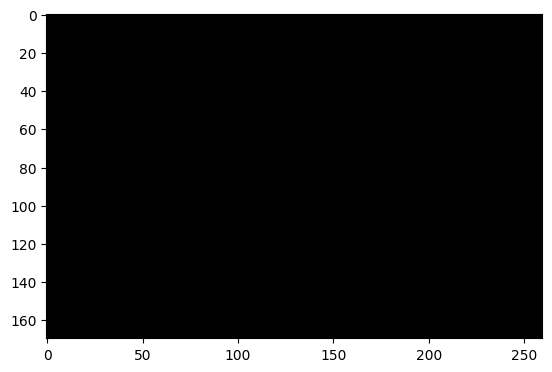

In [ ]:
env = gym.make("MiniHack-Navigation-Custom-v0", des_file="dat/fully_observable_NH.des", observation_keys=["chars", "pixel", "colors"])
solve_and_plt(env, heuristic=chebyshev_distance, precision="advanced", plt_width=(100, 270), plt_height=(500, 760), dynamic=True)

Let us examine the statistics concerning different the map configurations.

In these and the following charts, the label "unknown" refers to all the instances where the agent either won or lost without seeing which monster was on the map. In the first case, this probably happened because the agent appeared very close to the stairs and quickly reached them before the monster revealed itself (possibly hiding in the clouds). In the second case, the agent was likely killed by a ranged attack from a hidden monster. Another point to consider is that all the statistics are run over 500 episodes, with a maximum of 30 steps.

Initially, let us consider the map where both monsters have an equal probability of appearing.
The first histogram represents the total wins and losses: it is clear that the number of victories is significantly higher than the number of defeats, and this proves that our algorithm works in most cases.
The second histogram represents the total wins and losses for each type of monster. 

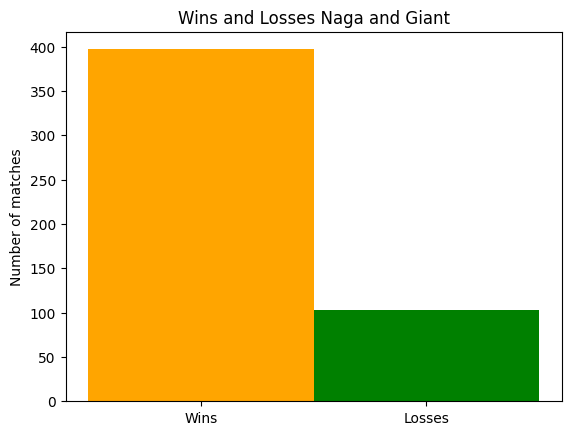

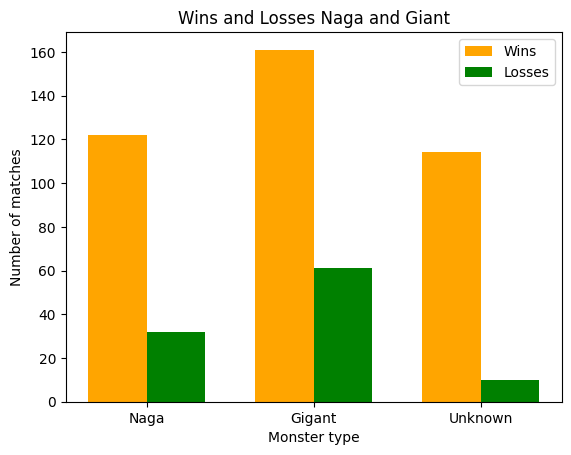

In [2]:
win, loss, monsters_win, monsters_loss = evaluate_performance("MiniHack-Navigation-Custom-v0", dynamic_path_finding, des_file="dat/fully_observable_NH.des", evaluation_steps=500)

labels = {
    "N": 'Naga',
    "H": 'Gigant',
    "L": 'Liches',
    "O": 'Ogre',
    "T": 'Troll',
    "D": 'Dragon',
    None: 'Unknown',
}

plot([win, loss], "1", 1, ["Wins", "Losses"], "Number of matches", "Wins and Losses Naga and Giant")

plot(monsters_win, "2", 0.35, labels, "Number of matches", "Wins and Losses Naga and Giant", monsters_loss, "Monster type")


Let us have a look at the performance over Naga and the Giant alone.

Generally, the win rate is higher in maps featuring only the giant compared to those with only the Naga. This is because, in maps with only the Naga, the agent tends to die more frequently without the monster being visible. This is due to the lethal long-range attack of the Naga, which hits the agent before the monster becomes visible. Additionally, the agent has no defenses against this type of attack, both because it lacks an inventory and because not seeing the monster fails to trigger the logic of the evasion mechanism in the algorithm.

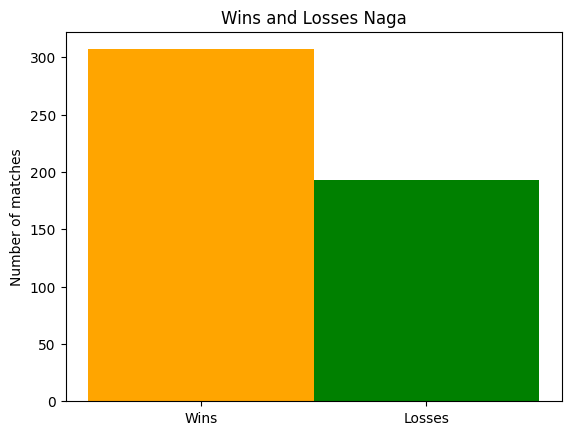

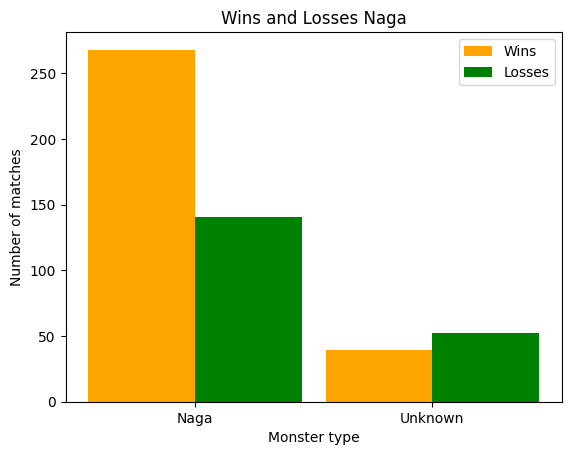

In [3]:
# NAGA
win, loss, monsters_win, monsters_loss = evaluate_performance("MiniHack-Navigation-Custom-v0", dynamic_path_finding, des_file="dat/fully_observable_N.des", evaluation_steps=500)


plot([win, loss], "1", 1, ["Wins", "Losses"], "Number of matches", "Wins and Losses Naga")

plot(monsters_win, "2", 0.45, labels, "Number of matches", "Wins and Losses Naga", monsters_loss, "Monster type")

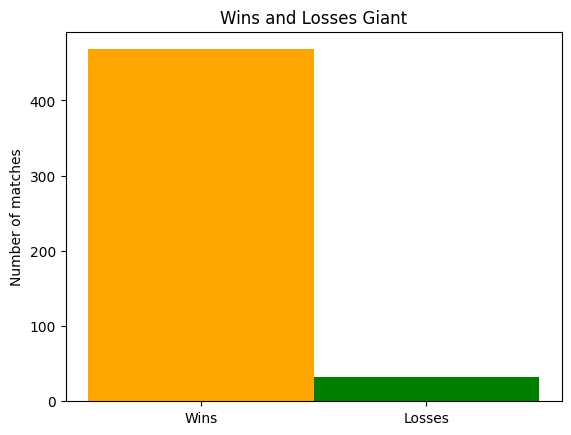

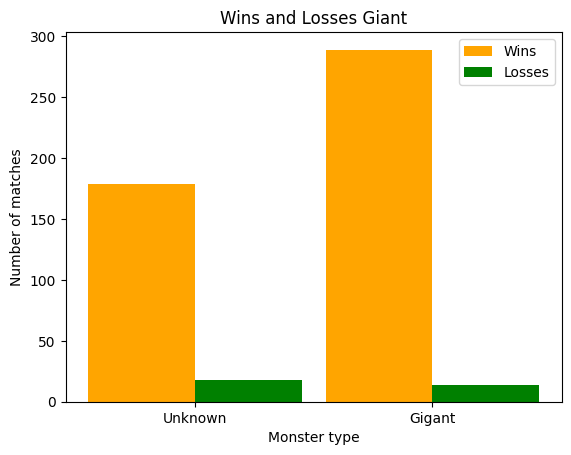

In [4]:
# GIANT
win, loss, monsters_win, monsters_loss = evaluate_performance("MiniHack-Navigation-Custom-v0", dynamic_path_finding, des_file="dat/fully_observable_H.des", evaluation_steps=500)


plot([win, loss], "1", 1, ["Wins", "Losses"], "Number of matches", "Wins and Losses Giant")

plot(monsters_win, "2", 0.45, labels, "Number of matches", "Wins and Losses Giant", monsters_loss, "Monster type")

Now, let us have a look at how the algorithm performs on the entire pool of monsters from HideNSeek. 

The algorithm remains effective even in this case, despite the increased difficulty that facing these monsters without an inventory can pose. In general, win and loss percentages are subject to various influencing factors, including the agent's proximity to the stairs (closer proximity increases the likelihood of reaching them without being killed) and the characteristics of the monster, coupled with its position relative to the agent (for example, favorable outcomes occur when a monster with a potent long-range attack is nearby). These variables are inherently unpredictable. 

Furthermore, in this specific context, the frequency of a monster's appearance in runs can impact the win rate, a variable beyond our control, as each monster has an equal probability of appearing on the map in every run.
Therefore, to comprehensively assess the effectiveness of our algorithm for each type of monster in HideNSeek, a rigorous evaluation would involve running the algorithm on individual maps for each monster type. However, despite this, we can assert the algorithm's general effectiveness based on its performance across 500 episodes.

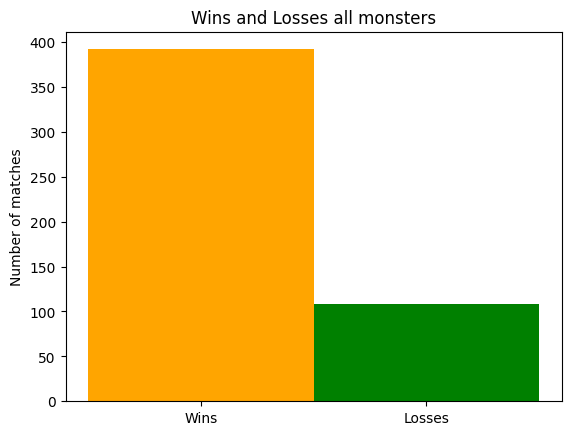

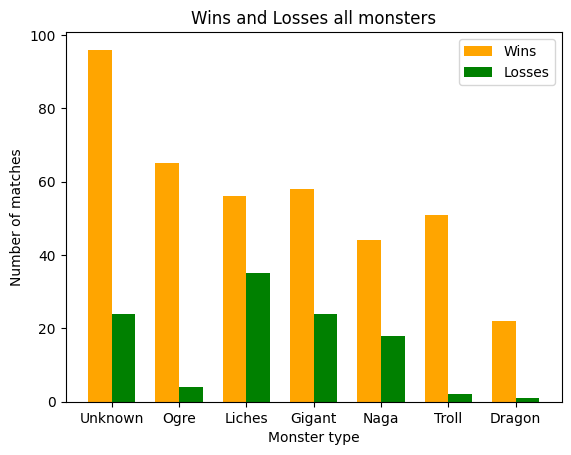

In [16]:
win, loss, monsters_win, monsters_loss = evaluate_performance("MiniHack-HideNSeek-Mapped-v0", dynamic_path_finding, evaluation_steps=500)


plot([win, loss], "1", 1, ["Wins", "Losses"], "Number of matches", "Wins and Losses all monsters")

plot(monsters_win, "2", 0.35, labels, "Number of matches", "Wins and Losses all monsters", monsters_loss, "Monster type")


In [ ]:
ml = [x for x in monsters_loss if x != None]
np.unique(ml, return_counts=True)

In [ ]:
from minihack import LevelGenerator

# Define the maze as a string
maze = """
...........
...........
...........
...........
...........
...........
...........
...........
...........
"""
# Set a start and goal positions
lvl_gen = LevelGenerator(map=maze,flags=('hardfloor','premapped'))
lvl_gen.set_start_pos((0,0))
lvl_gen.add_goal_pos((10,8))
# Add a Minotaur at fixed position
lvl_gen.add_monster(name="giant", place=(5,4))
lvl_gen.add_terrain((6,4),'C')
lvl_gen.add_terrain((1,0),'C')
lvl_gen.add_terrain((2,0),'T')
lvl_gen.add_terrain((4,0),'T')
lvl_gen.add_terrain((5,0),'T')
lvl_gen.add_terrain((7,0),'T')
lvl_gen.add_terrain((4,1),'C')
lvl_gen.add_terrain((6,1),'C')
lvl_gen.add_terrain((8,1),'C')
lvl_gen.add_terrain((0,2),'T')
lvl_gen.add_terrain((10,2),'C')
lvl_gen.add_terrain((0,3),'T')
lvl_gen.add_terrain((10,3),'C')
lvl_gen.add_terrain((1,3),'C')
lvl_gen.add_terrain((0,4),'T')
lvl_gen.add_terrain((8,4),'C')
lvl_gen.add_terrain((9,4),'C')
lvl_gen.add_terrain((1,4),'C')
lvl_gen.add_terrain((0,5),'C')
lvl_gen.add_terrain((1,5),'C')
lvl_gen.add_terrain((4,5),'C')
lvl_gen.add_terrain((9,5),'C')
lvl_gen.add_terrain((1,6),'T')
lvl_gen.add_terrain((5,6),'T')
lvl_gen.add_terrain((6,6),'C')
lvl_gen.add_terrain((10,6),'C')   
lvl_gen.add_terrain((4,7),'C')
lvl_gen.add_terrain((5,7),'C')
lvl_gen.add_terrain((6,7),'C')
lvl_gen.add_terrain((8,7),'C')   
lvl_gen.add_terrain((9,7),'T')    
lvl_gen.add_terrain((4,8),'T')
lvl_gen.add_terrain((1,8),'C')
lvl_gen.add_terrain((6,8),'C')
lvl_gen.add_terrain((7,8),'T')   
lvl_gen.add_terrain((8,8),'T')

The agent died.


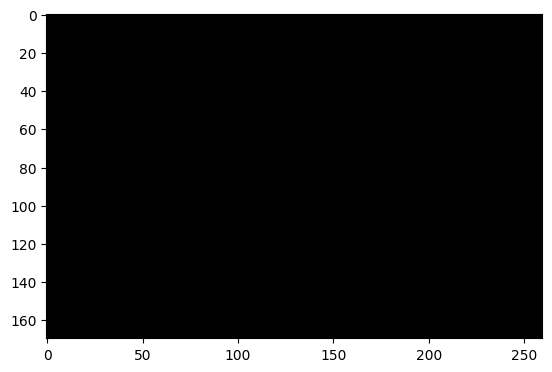

In [ ]:
env = gym.make("MiniHack-Navigation-Custom-v0",des_file= lvl_gen.get_des(), observation_keys=('chars','colors','pixel'))
solve_and_plt(env, heuristic=chebyshev_distance, precision="advanced", plt_width=(100, 270), plt_height=(500, 760), dynamic=True)

## 2. The Partially Observable Environment

In the partially observable environment, an agent's behavior must be adapted to handle the uncertainty and dynamics of the map. The main challenge in this scenario is the changing map configuration in each episode, making it impossible for the agent to rely on pre-existing knowledge or a predetermined path. Additionally, exploration becomes crucial since the stairs, which are the final objective, are not immediately visible.

If the stairs are visible, the agent will naturally choose them as the target. Otherwise, the simplest idea is to choose a random position on the frontier as a temporary target. The frontier in this context refers to the limits of the area currently visible to the agent. By moving towards these positions, the agent can explore new areas of the map, thereby increasing the likelihood of finding the stairs.


('W', None)

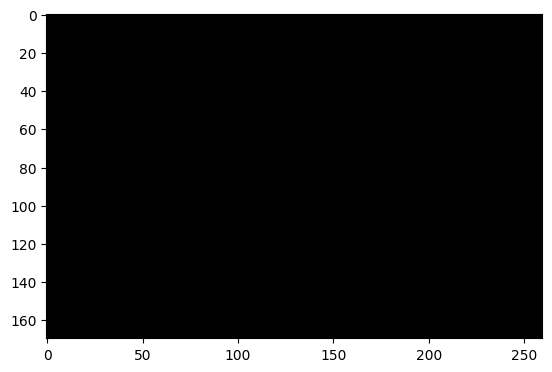

In [ ]:
env = gym.make("MiniHack-Navigation-Custom-v0", observation_keys=["chars", "pixel", "colors"], des_file="dat/partially_observable_simple.des")

state = env.reset()
game_map = state["chars"]
color_map = state["colors"]
pixel_map = state["pixel"]

start = get_player_location(game_map)

dynamic_pathfinding_po(game_map, color_map, start, env, chebyshev_distance,"advanced", True, True, pixel_map)
